In [3]:
import json
def analyze_json(filepath):
    # 读取JSON文件
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # 初始化计数器
    total_checks = 0
    total_results = 0
    total_yes = 0

    # 遍历每个元素，累计数值
    for item in data:
        # 统计 checks 的键值对数量
        total_checks += len(item.get('checks_once', {}))
        total_checks += len(item.get('checks_range', {}))
        total_checks += len(item.get('checks_periodic', {}))
        
        # 统计 results 的键值对数量
        results_once = item.get('results_once', {})
        results_range = item.get('results_range', {})
        results_periodic = item.get('results_periodic', {})
        
        total_results += len(results_once)
        total_results += len(results_range)
        total_results += len(results_periodic)

        # 累加值为 'yes' 的 results 的数量
        total_yes += sum(1 for key in results_once if results_once[key] == 'yes')
        total_yes += sum(1 for key in results_range if results_range.get(key, '') == 'yes')
        total_yes += sum(1 for key in results_periodic if results_periodic.get(key, '') == 'yes')

    # 输出结果
    print("Total checks key-value pairs:", total_checks)
    print("Total results key-value pairs:", total_results)
    print("Total 'yes' occurrences in results:", total_yes)

# 用实际的文件路径替换 'yourfile.json'
analyze_json('/home/yuhao/THREADING-THE-NEEDLE/Evalution/results/Qwen2-72B-Instruct_maxlen32000.json')


Total checks key-value pairs: 8215
Total results key-value pairs: 5189
Total 'yes' occurrences in results: 1428


In [3]:
import json
import os
import csv
import re

def calculate_completion_rate(type_to_block, total_number):
    identifiers = set(type_to_block.keys())
    expected_identifiers = set(range(1, total_number + 1))
    missing_identifiers = expected_identifiers - identifiers
    completion_rate = (len(expected_identifiers) - len(missing_identifiers)) / len(expected_identifiers)
    return completion_rate * 100
def parse_blocks(output_blocks, type):
    type_to_block = {}
    pattern = rf"{type} (\d+)"  # 假设类型后的数字仍有用，例如标识ID或序号
    for block in output_blocks:
        match = re.search(pattern, block)
        if match:
            identifier = int(match.group(1))  # 获取类型后的数字
            if identifier not in type_to_block or type_to_block[identifier] is None:
                type_to_block[identifier] = block

    return type_to_block

def analyze_json(filepath):
    # 初始化计数器
    total_checks = 0
    total_results = 0
    total_yes = 0
    total_word_count = 0
    word_count_entries = 0
    completion_rate = 0 
    
    # 读取JSON文件
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # 遍历每个元素，累计数值
    for item in data:
        # 统计 checks 的键值对数量
        total_checks += len(item.get('checks_once', {}))
        total_checks += len(item.get('checks_range', {}))
        total_checks += len(item.get('checks_periodic', {}))
        
        # 统计 results 的键值对数量
        results_once = item.get('results_once', {})
        results_range = item.get('results_range', {})
        results_periodic = item.get('results_periodic', {})
        
        total_results += len(results_once)
        total_results += len(results_range)
        total_results += len(results_periodic)

        # 累加值为 'yes' 的 results 的数量
        total_yes += sum(1 for key in results_once if results_once[key] == 'yes')
        total_yes += sum(1 for key in results_range if results_range.get(key, '') == 'yes')
        total_yes += sum(1 for key in results_periodic if results_periodic.get(key, '') == 'yes')
        
        # 累加符合条件的 word_count
        if 'output_blocks' in item and len(item['output_blocks']) > 40:
            if 'word_count' in item and item['word_count'] > 2000:
                total_word_count += item['word_count']
                word_count_entries += 1
        
        checks_block = parse_blocks(item['output_blocks'], item['type'])
        completion_rate += calculate_completion_rate(checks_block, item['number'])


    # 计算比率
    ratio_results_checks = total_results / total_checks if total_checks > 0 else None
    ratio_yes_results = total_yes / total_results if total_results > 0 else None
    ratio_yes_checks = total_yes / total_checks if total_checks > 0 else None
    completion_rate /= len(data) 

    # 计算平均 word_count
    average_word_count = total_word_count / word_count_entries if word_count_entries > 0 else None

    return [total_checks, total_results, total_yes, ratio_results_checks, ratio_yes_results, ratio_yes_checks, average_word_count,completion_rate]

def process_directory(directory_path):
    results = []
    # 遍历目录中的所有文件
    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            filepath = os.path.join(directory_path, filename)
            result = analyze_json(filepath)
            results.append([filename] + result)
    sorted_results = sorted(results, key=lambda x: x[0])
    # 将结果保存到 CSV 文件
    with open('static.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Filename', 'Total Checks', 'Total Results', 'Total Yes', 'Ratio Results/Checks', 'Ratio Yes/Results', 'Ratio Yes/Checks', 'Average Word Count','CR'])
        writer.writerows(sorted_results)

# 用实际的文件夹路径替换 'path_to_your_directory'
process_directory('/home/yuhao/THREADING-THE-NEEDLE/Evalution/results')


## draw section 2

In [6]:
import json

def load_and_count_keys(json_file_path):
    # 初始化键值为1到100的计数字典，同时统计键出现的总次数和值为 'yes' 的次数
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 52)}

    # 加载 JSON 文件
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # 遍历 JSON 文件中的每个元素
    for element in data:
        # 处理总键次数
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1

        # 处理值为 'yes' 的次数
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1

    # 打印统计结果
    for key, counts in key_count.items():
        if counts['total'] > 0:  # 防止除以零
            print(f"Key '{key}': Total count = {counts['total']}, 'Yes' count = {counts['yes']}, "
                  f"Ratio of 'Yes' = {counts['yes'] / counts['total']:.2f}")

# 假设 JSON 文件位于你的计算机上的以下路径

# 假设 JSON 文件位于你的计算机上的以下路径
json_file_path = '/home/yuhao/THREADING-THE-NEEDLE/Evalution/results/Meta-Llama-3.1-8B-Instruct_maxlen16000.json'
load_and_count_keys(json_file_path)


Key '1': Total count = 34, 'Yes' count = 8, Ratio of 'Yes' = 0.24
Key '2': Total count = 38, 'Yes' count = 2, Ratio of 'Yes' = 0.05
Key '3': Total count = 45, 'Yes' count = 18, Ratio of 'Yes' = 0.40
Key '4': Total count = 65, 'Yes' count = 11, Ratio of 'Yes' = 0.17
Key '5': Total count = 47, 'Yes' count = 14, Ratio of 'Yes' = 0.30
Key '6': Total count = 52, 'Yes' count = 10, Ratio of 'Yes' = 0.19
Key '7': Total count = 87, 'Yes' count = 24, Ratio of 'Yes' = 0.28
Key '8': Total count = 41, 'Yes' count = 9, Ratio of 'Yes' = 0.22
Key '9': Total count = 47, 'Yes' count = 15, Ratio of 'Yes' = 0.32
Key '10': Total count = 54, 'Yes' count = 15, Ratio of 'Yes' = 0.28
Key '11': Total count = 75, 'Yes' count = 11, Ratio of 'Yes' = 0.15
Key '12': Total count = 66, 'Yes' count = 22, Ratio of 'Yes' = 0.33
Key '13': Total count = 83, 'Yes' count = 21, Ratio of 'Yes' = 0.25
Key '14': Total count = 73, 'Yes' count = 18, Ratio of 'Yes' = 0.25
Key '15': Total count = 87, 'Yes' count = 16, Ratio of 'Yes'

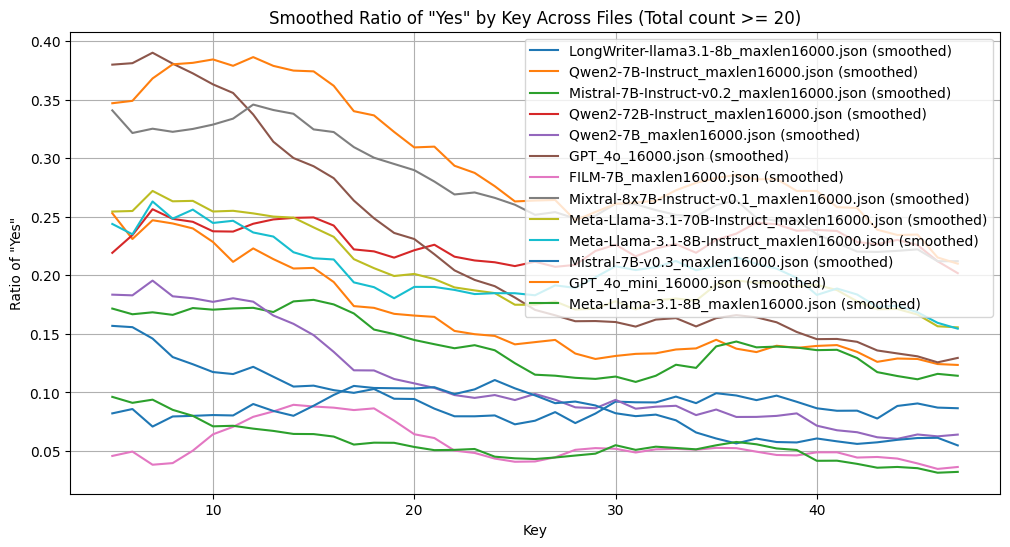

In [32]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

def load_and_count_keys(json_file_path):
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 53)}

    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for element in data:
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1

    return key_count





def plot_yes_ratios(all_key_counts, window_size=10):
    plt.figure(figsize=(12, 6))

    for file_name, key_count in all_key_counts.items():
        x_vals = []
        y_vals = []
        for key, counts in key_count.items():
            if counts['total'] >= 20:
                ratio = counts['yes'] / counts['total'] if counts['total'] > 0 else 0
                x_vals.append(int(key))
                y_vals.append(ratio)

        # Calculate moving average
        if len(y_vals) >= window_size:
            weights = np.ones(window_size) / window_size
            y_smooth = np.convolve(y_vals, weights, mode='valid')

            # Explicitly adjust x_vals to match the exact length of y_smooth
            # Start index for x_vals is (window_size - 1) // 2 to center the window
            start_index = (window_size - 1) // 2
            x_smooth = x_vals[start_index:start_index + len(y_smooth)]

            plt.plot(x_smooth, y_smooth, label=f'{file_name} (smoothed)')

    plt.title('Smoothed Ratio of "Yes" by Key Across Files (Total count >= 20)')
    plt.xlabel('Key')
    plt.ylabel('Ratio of "Yes"')
    plt.grid(True)
    plt.legend()
    plt.show()



def process_files_in_directory(directory_path):
    all_key_counts = {}
    for file in os.listdir(directory_path):
        if "16000" in file and file.endswith('.json'):
            file_path = os.path.join(directory_path, file)
            key_counts = load_and_count_keys(file_path)
            all_key_counts[file] = key_counts

    plot_yes_ratios(all_key_counts)

# Usage
directory_path = '/home/yuhao/THREADING-THE-NEEDLE/Evalution/results'
process_files_in_directory(directory_path)


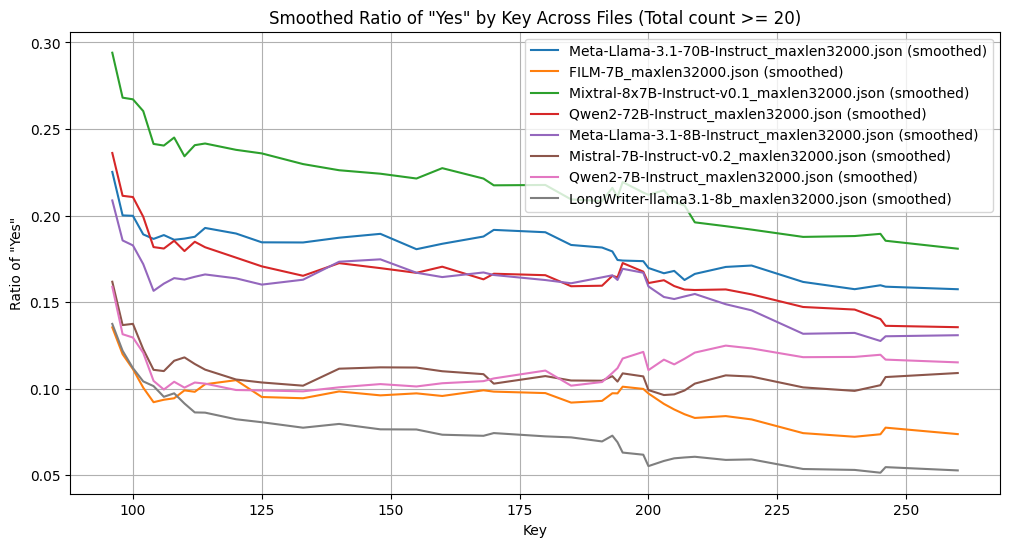

In [37]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

def load_and_count_keys(json_file_path):
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 300)}

    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for element in data:
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1

    return key_count





def plot_yes_ratios(all_key_counts, window_size=20):
    plt.figure(figsize=(12, 6))

    for file_name, key_count in all_key_counts.items():
        x_vals = []
        y_vals = []
        for key, counts in key_count.items():
            if counts['total'] >= 30:
                ratio = counts['yes'] / counts['total'] if counts['total'] > 0 else 0
                x_vals.append(int(key))
                y_vals.append(ratio)

        # Calculate moving average
        if len(y_vals) >= window_size:
            weights = np.ones(window_size) / window_size
            y_smooth = np.convolve(y_vals, weights, mode='valid')

            # Explicitly adjust x_vals to match the exact length of y_smooth
            # Start index for x_vals is (window_size - 1) // 2 to center the window
            start_index = (window_size - 1) // 2
            x_smooth = x_vals[start_index:start_index + len(y_smooth)]

            plt.plot(x_smooth, y_smooth, label=f'{file_name} (smoothed)')

    plt.title('Smoothed Ratio of "Yes" by Key Across Files (Total count >= 20)')
    plt.xlabel('Key')
    plt.ylabel('Ratio of "Yes"')
    plt.grid(True)
    plt.legend()
    plt.show()



def process_files_in_directory(directory_path):
    all_key_counts = {}
    for file in os.listdir(directory_path):
        if "32000" in file and file.endswith('.json'):
            file_path = os.path.join(directory_path, file)
            key_counts = load_and_count_keys(file_path)
            all_key_counts[file] = key_counts

    plot_yes_ratios(all_key_counts)

# Usage
directory_path = '/home/yuhao/THREADING-THE-NEEDLE/Evalution/results'
process_files_in_directory(directory_path)
